In [1]:
#Gasoline_df, Crude_df, and WTI_prices have been split up 
#because they have different headers that have to be handled differently.

In [2]:
# pip install EIA-python

In [3]:
import numpy as np
import pandas as pd
import calendar
#import time dependencies
from datetime import datetime
import time
from datetime import date, timedelta
import datetime
#import statistics dependencies
from scipy.stats import linregress
#import matplotlib dependencies
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from matplotlib import style
style.use(['classic','dark_background'])
# Import the API key.
from config import EIA_key
import eia
# Import the requests library.
import requests
import matplotlib as mpl
#Suppress Warnings
pd.options.mode.chained_assignment = None  # default='warn'

#### Dates for Crude Prices and Storage

In [4]:
#this is the start and end date for matplotlib
start_date = "2013-09-01"
end_date =  datetime.datetime.now() 
# end_date= datetime.datetime.now() 

# DUC Inventory API

In [5]:
# There is no API for DUC Inventory
# https://www.eia.gov/petroleum/drilling/

In [6]:
##############Read in csv, get rid of columns, clean up data and convert columns#############
DUCInventory='Data/duc-data.csv'
DUCInventory_df=pd.read_csv(DUCInventory, header=[3]) 
DUCInventory_df.columns = ['Date','Anadarko_Drilled','Anadarko_Completed','Anadarko_DUC','Unnamed: 4','Appalachia_Drilled','Appalachia_Completed','Appalachia_DUC','Unnamed: 8','Bakken_Drilled','Bakken_Completed','Bakken_DUC','Unnamed: 12','Eagle Ford_Drilled','Eagle Ford_Completed', 'Eagle Ford_DUC', 'Unnamed: 16','Haynesville_Drilled','Haynesville_Completed','Haynesville_DUC', 'Unnamed: 20', 'Niobrara_Drilled','Niobrara_Completed', 'Niobrara_DUC','Unnamed: 24','Permian_Drilled','Permian_Completed', 'Permian_DUC','Unnamed: 28', 'Total_Drilled','Total_Completed','Total_DUC']                                         
DUCInventory_df=DUCInventory_df.iloc[1:87, ]
# DUCInventory_df=DUCInventory_df.dropna()
DUCInventory_df=DUCInventory_df[['Date','Anadarko_DUC','Appalachia_DUC','Bakken_DUC','Eagle Ford_DUC','Haynesville_DUC','Niobrara_DUC','Permian_DUC', 'Total_DUC']]
#if have a date format like Jan-14 for the month and year:
#then you can use pd.to_datetime(df['column'], format=%b-%y)
DUCInventory_df['Date'] = pd.to_datetime(DUCInventory_df["Date"], format='%b-%y')
DUCInventory_df.set_index('Date', inplace=True) 

In [7]:
DUCInventory_df.tail() 

,Anadarko_DUC,Appalachia_DUC,Bakken_DUC,Eagle Ford_DUC,Haynesville_DUC,Niobrara_DUC,Permian_DUC,Total_DUC
Date,,,,,,,,
2020-10-01,827,605,778.0,"1,126",336.0,664.0,"3,521","7,857"
2020-11-01,806,593,756.0,"1,093",324.0,614.0,"3,413","7,599"
2020-12-01,784,581,726.0,"1,062",318.0,573.0,"3,333","7,377"
2021-01-01,764,564,702.0,"1,033",313.0,537.0,"3,275","7,188"
2021-02-01,751,550,680.0,"1,011",314.0,507.0,"3,273","7,086"


In [8]:
#The data was an object, so we need to convert that to an int to get rid of the commas, 
#convt to a string and then to an int
shalePlays=['Anadarko_DUC','Appalachia_DUC','Bakken_DUC','Eagle Ford_DUC','Haynesville_DUC','Niobrara_DUC','Permian_DUC', 'Total_DUC'] 
for i in shalePlays:
    DUCInventory_df[i]=pd.to_numeric(DUCInventory_df[i].astype(str).str.replace(',',''), errors='coerce')

In [9]:
#Date control for line graphs
DUCInventory_date_df = DUCInventory_df[(DUCInventory_df.index> start_date) & (DUCInventory_df.index< end_date)]
#Date control for bar and pie charts
DUCInventory_now_df=DUCInventory_df[-3:]

In [10]:
DUCInventory_date_df

,Anadarko_DUC,Appalachia_DUC,Bakken_DUC,Eagle Ford_DUC,Haynesville_DUC,Niobrara_DUC,Permian_DUC,Total_DUC
Date,,,,,,,,
2014-01-01,382,1270,605.0,992,125.0,475.0,651,4500
2014-02-01,380,1307,657.0,1055,137.0,521.0,714,4771
2014-03-01,344,1250,663.0,1009,135.0,505.0,699,4605
2014-04-01,338,1278,673.0,1075,125.0,505.0,724,4718
2014-05-01,314,1257,691.0,1093,119.0,536.0,749,4759
...,...,...,...,...,...,...,...,...
2020-10-01,827,605,778.0,1126,336.0,664.0,3521,7857
2020-11-01,806,593,756.0,1093,324.0,614.0,3413,7599
2020-12-01,784,581,726.0,1062,318.0,573.0,3333,7377


# Gasoline/Crude Storage/Crude Prices API

In [11]:
#might need to fix api call and change the series_id at the end
API_Call=f"http://api.eia.gov/series/?api_key={EIA_key}&series_id=PET.WCESTUS1.W"
Series_Name_Gasoline= "U.S. Ending Stocks of Total Gasoline, Weekly"
Series_Name_Crude='U.S. Ending Stocks excluding SPR of Crude Oil, Weekly'
Series_Name_Price='West Texas Intermediate Crude Oil Price, Monthly'
Series_ID_Gasoline= "PET.WGTSTUS1.W"
Series_ID_Crude="PET.WCESTUS1.W"
Series_ID_Prices="STEO.WTIPUUS.M"
#install EIA package--- pip install EIA_python
#pip install pyOpenSSL to get around SSL error
#these are the API keys I set up
api_key = EIA_key
api = eia.API(api_key)


#import Gasoline data but still need to clean it
series_search = api.data_by_series(series=Series_ID_Gasoline)
gasoline_df = pd.DataFrame(series_search)

#import Crude data but still need to clean it
series_search = api.data_by_series(series=Series_ID_Crude)
crude_df = pd.DataFrame(series_search)

In [12]:
#import Gasoline data but still need to clean it
series_search = api.data_by_series(series=Series_ID_Gasoline)
gasoline_df = pd.DataFrame(series_search)
# define a series and pass through api and Series_ID
def retrieve_time_series(api, Series_ID_Gasoline):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=Series_ID_Gasoline)
    ##Create a pandas dataframe from the retrieved time series
    global gasoline_df
    gasoline_df = pd.DataFrame(series_search)
    return gasoline_df
# define another function main to run the script through
def main():
    """
    Run main script
    """
    #Create EIA API using your specific API key
    api_key = EIA_key
    api = eia.API(api_key)
#     #Declare desired series ID
#     Series_ID="PET.WGTSTUS1.W"
    gasoline_df=retrieve_time_series(api, Series_ID_Gasoline)
    #Print the returned dataframe df
    print(df)
req = requests.get(API_Call, verify = False)

#Clean the dataframe by resetting the index because the date is automatically set as the index
gasoline_df.reset_index(inplace=True)
gasoline_df.rename(columns={'U.S. Ending Stocks of Total Gasoline, Weekly (Thousand Barrels)':'Gas Storage'}, inplace=True)
gasoline_df.rename(columns={'index':'Date'}, inplace=True)


#the days were repeated so we need to drop the last two days
test=gasoline_df['Date']
length = len(test)          # for reading and writing sakes, len(A): lenght of A
newtest = [None] * length          # newtest = [none, none, none], go look up empty array creation
strLen = 0 

for i in range(0, length):             # for loop
    str = test[i]                      # get n th element of test
    strLen = len(str)                  # for reading sake, the lenght of string that will be spliced
    gasoline_df['Date'][i] = str[0:strLen - 3] # n th element of newtest is the spliced n th element from test
    
print(gasoline_df)

#the rest of the dates are in a weird format so we have to get them into %Y%m%d format and then convert to datetime
def format_date(row_value):
    #split string on space and slice out the first two parts
    year=row_value.split(" ")[0]
    month=row_value.split(" ")[1][:2]
    day = row_value.split(" ")[1][2:]
    return f"{year}{month}{day}"
gasoline_df['Date']=gasoline_df['Date'].map(format_date)
gasoline_df['Date']=pd.to_datetime(gasoline_df['Date'].astype(int), format='%Y%m%d')

           Date  Gas Storage
0     1990 0105       210982
1     1990 0112       215395
2     1990 0119       219221
3     1990 0126       229695
4     1990 0202       234249
...         ...          ...
1623  2021 0212       257084
1624  2021 0219       257096
1625  2021 0226       243472
1626  2021 0305       231603
1627  2021 0312       232075

[1628 rows x 2 columns]


In [13]:
#import Crude data but still need to clean it
series_search = api.data_by_series(series=Series_ID_Crude)
crude_df = pd.DataFrame(series_search)
# define a series and pass through api and Series_ID
def retrieve_time_series(api, Series_ID_Crude):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=Series_ID_Crude)
    ##Create a pandas dataframe from the retrieved time series
    global crude_df
    crude_df = pd.DataFrame(series_search)
    return crude_df
# define another function main to run the script through
def main():
    """
    Run main script
    """
    #Create EIA API using your specific API key
    api_key = EIA_key
    api = eia.API(api_key)
#     #Declare desired series ID
#     Series_ID="PET.WGTSTUS1.W"
    df=retrieve_time_series(api, Series_ID_Crude)
    #Print the returned dataframe df
    print(df)
req = requests.get(API_Call, verify = False)

#Clean the dataframe by resetting the index because the date is automatically set as the index
crude_df.reset_index(inplace=True)
crude_df.rename(columns={'U.S. Ending Stocks excluding SPR of Crude Oil, Weekly (Thousand Barrels)':'Crude'}, inplace=True)
crude_df.rename(columns={'index':'Date'}, inplace=True)


#the days were repeated so we need to drop the last two days
test=crude_df['Date']
length = len(test)          # for reading and writing sakes, len(A): lenght of A
newtest = [None] * length          # newtest = [none, none, none], go look up empty array creation
strLen = 0 

for i in range(0, length):             # for loop
    str = test[i]                      # get n th element of test
    strLen = len(str)                  # for reading sake, the lenght of string that will be spliced
    crude_df['Date'][i] = str[0:strLen - 3] # n th element of newtest is the spliced n th element from test



#the rest of the dates was in a weird format so we have to get them into %Y%m%d format and then convert to datetime
def format_date(row_value):
    #split string on space and slice out the first two parts
    year=row_value.split(" ")[0]
    month=row_value.split(" ")[1][:2]
    day = row_value.split(" ")[1][2:]
    return f"{year}{month}{day}"
crude_df['Date']=crude_df['Date'].map(format_date)
crude_df['Date']=pd.to_datetime(crude_df['Date'].astype(int), format='%Y%m%d')

In [14]:
#import Pricing data but still need to clean it
series_search = api.data_by_series(series=Series_ID_Prices)
WTI_df= pd.DataFrame(series_search)
# define a series and pass through api and Series_ID
def retrieve_time_series(api, Series_ID_Prices):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=Series_ID_Prices)
    ##Create a pandas dataframe from the retrieved time series
    global WTI_df
    WTI_df = pd.DataFrame(series_search)
    return df
# define another function main to run the script through
def main():
    """
    Run main script
    """
    #Create EIA API using your specific API key
    api_key = EIA_key
    api = eia.API(api_key)
#     #Declare desired series ID
#     Series_ID="PET.WGTSTUS1.W"
    WTI_df=retrieve_time_series(api, Series_ID_Prices)
    #Print the returned dataframe df
    print(df)
req = requests.get(API_Call, verify = False)

#Clean the dataframe by resetting the index because the date is automatically set as the index
WTI_df.reset_index(inplace=True)
WTI_df.rename(columns={'West Texas Intermediate Crude Oil Price, Monthly (dollars per barrel)':'Crude Price'}, inplace=True)
WTI_df.rename(columns={'index':'Date'}, inplace=True)

WTI_df['Date']=WTI_df['Date'].map(format_date)
WTI_df['Date']=pd.to_datetime(WTI_df['Date'].astype(int), format='%Y%m')

In [15]:
gasoline_date_df=gasoline_df[(gasoline_df['Date']>start_date) & (gasoline_df['Date']< end_date)]
crude_date_df=crude_df[(crude_df['Date']>start_date) & (crude_df['Date']< end_date)]
WTI_date_df=WTI_df[(WTI_df['Date']>start_date) & (WTI_df['Date']< end_date)] 

# DUC Graphs Visualizations

#### Total DUC Inventory

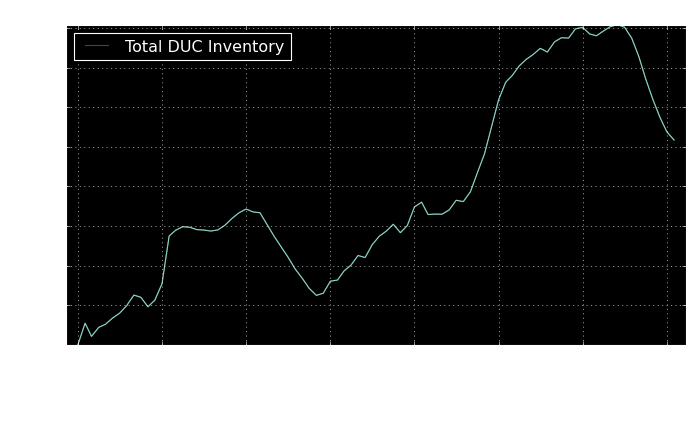

In [16]:
fig, ax=plt.subplots(frameon=False, figsize=(10,5))

ax.set_xlabel('Date')
ax.set_ylabel('DUC Inventory')
ax.plot(DUCInventory_df.index,DUCInventory_df['Total_DUC'], color='darkslategrey')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=45)
# ax.tick_params(axis='y', length= 10)
ax.set_title("Total DUC Inventory")
ax.grid()
plt.margins(x=.02)

# defining legend style and data
blue_line = mlines.Line2D([], [], color='darkslategrey', label='Total DUC Inventory')
plt.legend(handles=[blue_line], loc='upper left')
plt.savefig("Total DUC Inventory.png", bbox_inches='tight')
#This is where the blune line comes from
plt.plot(DUCInventory_date_df.index,DUCInventory_date_df['Total_DUC'])
plt.savefig("DUC_Images/Line_Graph_Total_DUC.png", bbox_inches='tight')
plt.show()

#### DUC Inventory By Major Shale Region Line Chart

[]

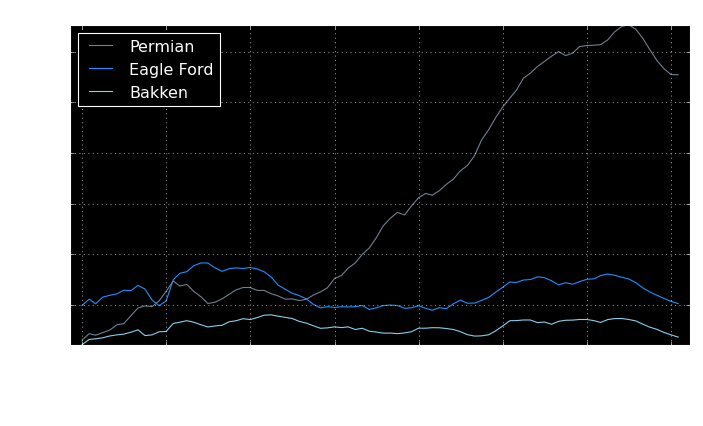

In [17]:
from matplotlib.ticker import FixedLocator, LinearLocator, FormatStrFormatter
# plot just crude prices on one graph
fig, ax=plt.subplots(frameon=False, figsize=(10,5))

Plays=['Bakken_DUC','Eagle Ford_DUC','Permian_DUC']
Colors=['skyblue','dodgerblue','slategrey']
for i,j in zip(Plays,Colors):
    ax.plot(DUCInventory_date_df.index,DUCInventory_date_df[i], color=j)

show_every = 10
sparse_xticks = [None] * DUCInventory_date_df.index.shape[0]
sparse_xticks[::show_every] = DUCInventory_date_df.index[::show_every]
ax.set_xticklabels(sparse_xticks, fontsize=12)   # set sparse xtick values

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=45)
ax.set_title("DUC Inventory By Major Shale Region")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.grid()
plt.margins(x=.02)
ax.set_xlabel('Date')
ax.set_ylabel('DUC Inventory')
# defining legend style and data
lineOne = mlines.Line2D([], [], color='slategrey', label='Permian')
lineTwo = mlines.Line2D([], [], color='skyblue', label='Bakken')
lineThree = mlines.Line2D([], [], color='dodgerblue', label='Eagle Ford')
plt.legend(handles=[lineOne, lineThree, lineTwo], loc='upper left')
plt.savefig("DUC_Images/Line_Graph_Permian_EF_Bakken.png", bbox_inches='tight')
plt.plot()

In [18]:
# When adding in new DUC CSVs then you have to update the start_date_now_DUC to the last three months
DUCInventory_now_df

,Anadarko_DUC,Appalachia_DUC,Bakken_DUC,Eagle Ford_DUC,Haynesville_DUC,Niobrara_DUC,Permian_DUC,Total_DUC
Date,,,,,,,,
2020-12-01,784,581,726.0,1062,318.0,573.0,3333,7377
2021-01-01,764,564,702.0,1033,313.0,537.0,3275,7188
2021-02-01,751,550,680.0,1011,314.0,507.0,3273,7086


#### DUC Inventory By Shale Play Bar Chart

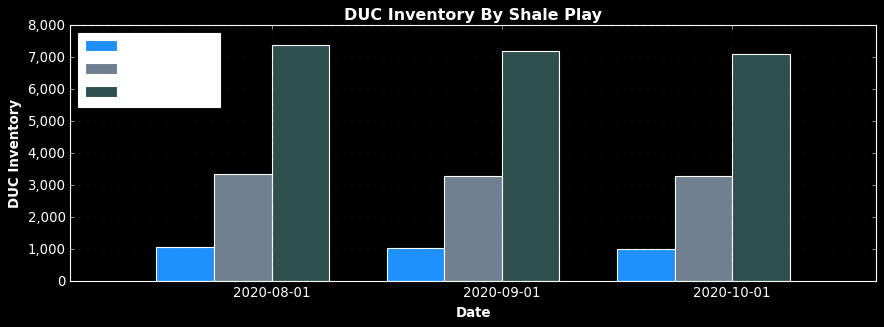

<Figure size 640x480 with 0 Axes>

In [19]:
#pandas does not know datetime so turn it into pandas.Timestamp into datetime
f=DUCInventory_now_df.index.to_pydatetime()
figure, ax=plt.subplots(figsize=(13,4))

number_groups=len(['Eagle Ford_DUC', 'Permian_DUC',  'Total_DUC'])
numerical=[DUCInventory_now_df['Eagle Ford_DUC'],DUCInventory_now_df['Permian_DUC'],DUCInventory_now_df['Total_DUC']]
bin_width=1.0/(number_groups+1)
colors = ['dodgerblue', 'slategrey', 'darkslategrey'] 


for i in range(number_groups):
    ax.bar(x=np.arange(len([ 'Eagle Ford_DUC', 'Permian_DUC','Total_DUC']))+ i*bin_width,
          height=numerical[i],
          width=bin_width,
          color=colors[i])
ax.set_xticks(np.arange(len(['Eagle Ford_DUC', 'Permian_DUC',  'Total_DUC'])) + number_groups/(2*(number_groups+1)))

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# number_groups/(2*(number_groups+1)): offset of xticklabel
ax.set_xticklabels(['2020-08-01', '2020-09-01', '2020-10-01'])
ax.legend(['Eagle Ford', 'Permian', 'Total'], loc='upper left', facecolor='w')
# ax.gird()
plt.xlabel('Date', fontweight='bold')
plt.ylabel('DUC Inventory', fontweight='bold')
plt.title ("DUC Inventory By Shale Play", fontweight='bold')
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.2) 
plt.show()
plt.savefig('DUC_Images/DUC_Inventory_Bar.png', bbox_inches='tight')

#### DUC Inventory By Major Shale Play Bar Chart

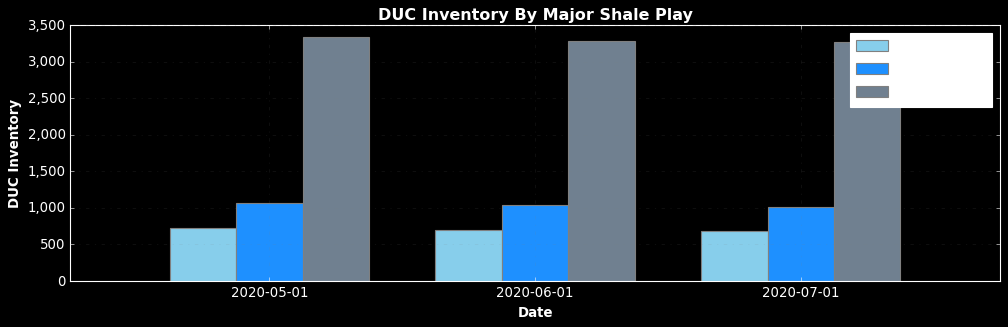

<Figure size 640x480 with 0 Axes>

In [20]:
#pandas does not know datetime so turn it into pandas.Timestamp into datetime
f=DUCInventory_now_df.index.to_pydatetime()
figure, ax=plt.subplots(figsize=(15,4)) 
bars1=[0.25,0.5,0.75]
barWidth=0.25

# Set position of bar on X axis 
br1 = np.arange(len(bars1)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2]
#set the plot
br=[br1, br2, br3]
Plays=['Bakken_DUC','Eagle Ford_DUC','Permian_DUC']
Color=['skyblue','dodgerblue','slategrey']
for w,i,j in zip(br,Plays,Color):
    plt.bar(w,DUCInventory_now_df[i], color=j, width=barWidth, edgecolor='grey')

plt.xticks([r + barWidth for r in range(len(DUCInventory_now_df['Bakken_DUC']))], 
           ['2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01'])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.2) 
ax.legend(['Bakken', 'Eagle Ford', 'Permian'], facecolor='w')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('DUC Inventory', fontweight='bold')
plt.title ("DUC Inventory By Major Shale Play", fontweight='bold')
plt.show()
plt.savefig('DUC_Images/Bar_Chart_3_months_Permiman_Bakken_EF.png', bbox_inches='tight')

#### DUC Inventory By Basin Pie Chart

C:\Users\15124\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


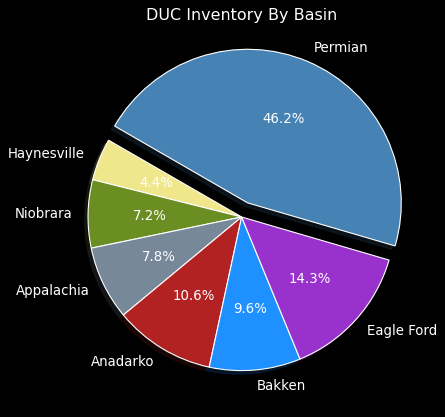

In [21]:
pie_df=DUCInventory_now_df[2:][['Haynesville_DUC','Niobrara_DUC', 'Appalachia_DUC','Anadarko_DUC','Bakken_DUC','Eagle Ford_DUC','Permian_DUC']]
## Build percentage of rides by city type pie chart.
plt.subplots(figsize=(10, 6))
plt.pie(pie_df,
    labels=[ "Haynesville", "Niobrara", "Appalachia", "Anadarko", "Bakken", "Eagle Ford","Permian"],
    colors=["khaki", "olivedrab",  "lightslategrey", "firebrick",  'dodgerblue','darkorchid','steelblue'],
    explode=[0, 0, 0,0,0,0,0.1],
    autopct='%1.1f%%',
    shadow=True, startangle=150)
plt.title("DUC Inventory By Basin")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# Change the default font size from 10 to 14.
mpl.rcParams['font.size'] = 14
plt.savefig("DUC_Images/Pie_Chart_DUCs.png", bbox_inches='tight')
plt.show()

#### DUC Inventory By Region Line Chart

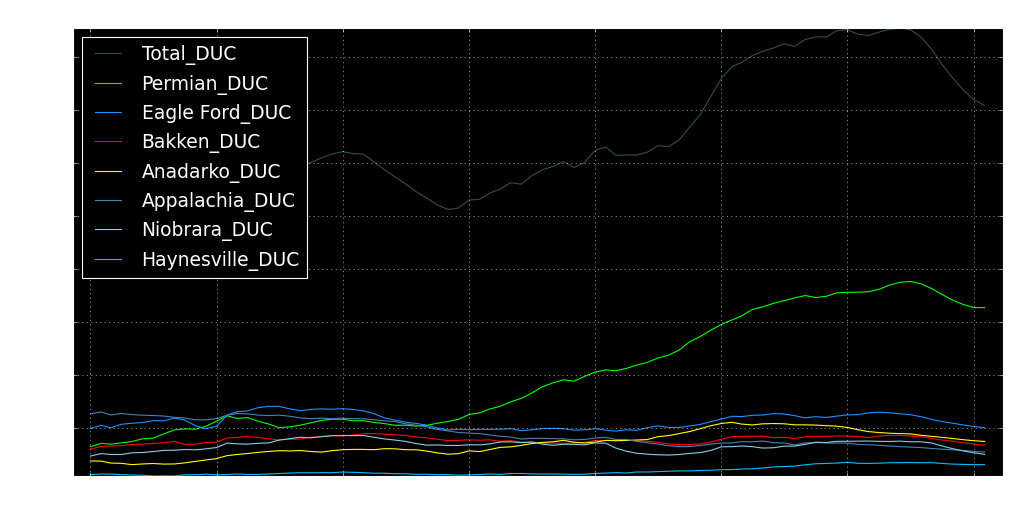

In [22]:
from matplotlib.ticker import FixedLocator, LinearLocator, FormatStrFormatter
# plot just crude prices on one graph
fig, ax=plt.subplots(frameon=False, figsize=(15,7))
plt.margins(x=.02)
Labels=[]
Plays=[ 'Total_DUC', 'Permian_DUC',  'Eagle Ford_DUC', 'Bakken_DUC', 'Anadarko_DUC', 'Appalachia_DUC', 'Niobrara_DUC', 'Haynesville_DUC']
Colors=['darkslategrey', 'lime','dodgerblue',     'red',     'yellow',     'steelblue',       'skyblue',  'deepskyblue']
for i,j in zip(Plays,Colors):
    ax.plot(DUCInventory_date_df.index,DUCInventory_date_df[i], color=j)
    line=mlines.Line2D([], [], color=j, label='[i]')
    plt.legend(['Total_DUC', 'Permian_DUC',  'Eagle Ford_DUC', 'Bakken_DUC', 'Anadarko_DUC', 'Appalachia_DUC', 'Niobrara_DUC', 'Haynesville_DUC'], loc='upper left')      

_=plt.xticks(rotation=45)
plt.ylabel('DUC Inventory')
plt.title('DUC Inventory By Region')
plt.savefig("DUC_Images/DUC_Inventory_By_Region.png", bbox_inches='tight')
plt.grid()
plt.show()

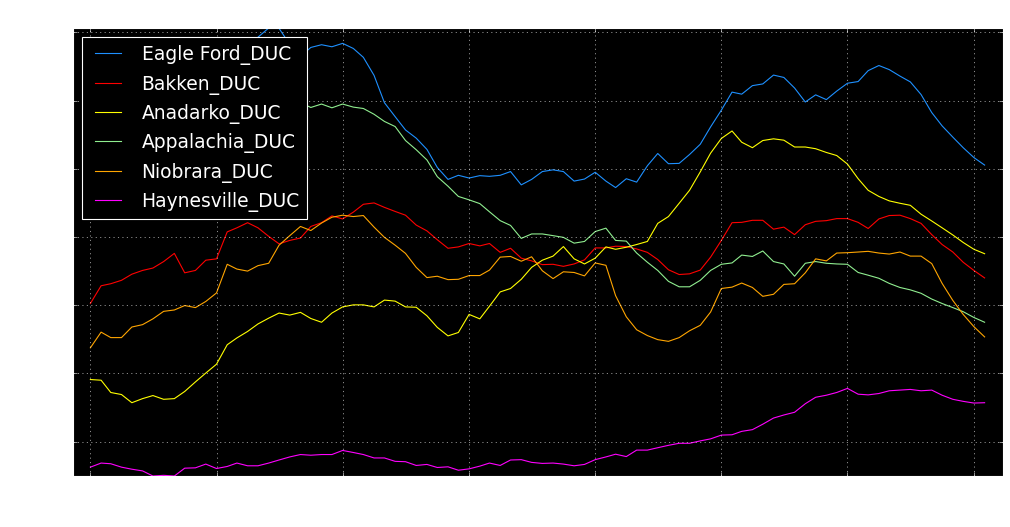

In [23]:
from matplotlib.ticker import FixedLocator, LinearLocator, FormatStrFormatter
# plot just crude prices on one graph
fig, ax=plt.subplots(frameon=False, figsize=(15,7))
plt.margins(x=.02)
Labels=[]
Plays=[ 'Eagle Ford_DUC', 'Bakken_DUC', 'Anadarko_DUC', 'Appalachia_DUC', 'Niobrara_DUC', 'Haynesville_DUC']
Colors=['dodgerblue',     'red',          'yellow',     'lightgreen',      'orange',        'magenta']
for i,j in zip(Plays,Colors):
    ax.plot(DUCInventory_date_df.index,DUCInventory_date_df[i], color=j)
    line=mlines.Line2D([], [], color=j, label='[i]')
    plt.legend(['Eagle Ford_DUC', 'Bakken_DUC', 'Anadarko_DUC', 'Appalachia_DUC', 'Niobrara_DUC', 'Haynesville_DUC'], loc='upper left')      

_=plt.xticks(rotation=45)
plt.ylabel('DUC Inventory')
plt.title('DUC Inventory By Region Without Permian')
plt.savefig("DUC_Images/DUC_Inventory_By_RegionWOPermian.png", bbox_inches='tight')
plt.grid()
plt.show()

# Crude Prices and Storage Visualizations

#### Gasoline Stocks

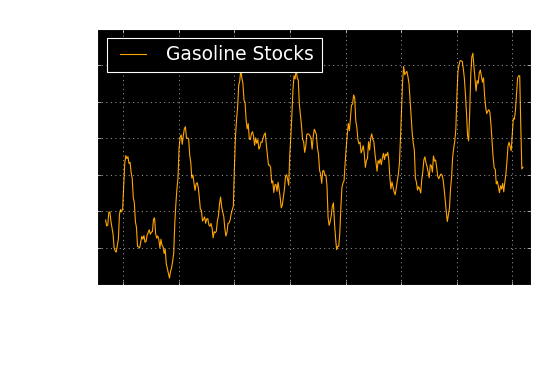

In [24]:
# plot just crude prices on one graph
fig, ax1=plt.subplots(frameon=False, figsize=(7,4))

ax1.set_xlabel('Date')
ax1.set_ylabel('Gasoline Storage')
ax1.plot(gasoline_date_df['Date'],gasoline_date_df['Gas Storage'], color='orange')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=45)
ax1.tick_params(axis='y')
ax1.set_title("Gasoline Stocks")
plt.margins(x=.02)

ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.grid()

# defining legend style and data
blue_line = mlines.Line2D([], [], color='orange', label='Gasoline Stocks')
plt.legend(handles=[blue_line], loc='upper left')
plt.savefig("Crude_Storage_Images/GasolineAPI.png", bbox_inches='tight')

#### Crude Stocks

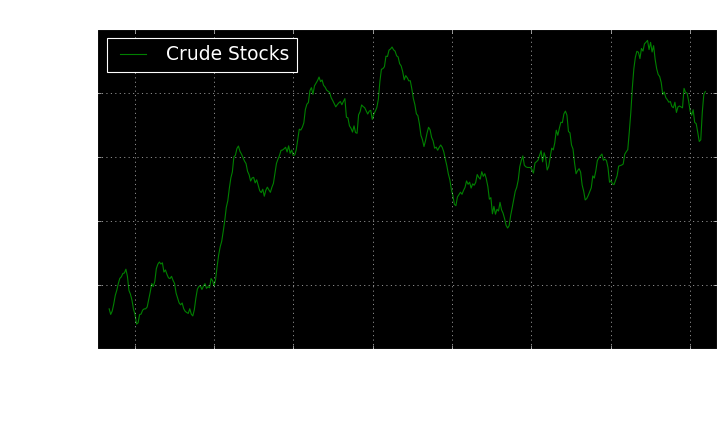

In [25]:
# plot just crude prices on one graph
fig, ax1=plt.subplots(frameon=False, figsize=(10,5))

ax1.set_xlabel('Date')
ax1.set_ylabel('Crude Storage')
ax1.plot(crude_date_df['Date'],crude_date_df['Crude'], color='g')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=45)
ax1.tick_params(axis='y')
ax1.set_title("Crude Stocks")
plt.margins(x=.02)
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.grid()

# defining legend style and data
blue_line = mlines.Line2D([], [], color='g', label='Crude Stocks')
plt.legend(handles=[blue_line], loc='upper left')
plt.savefig("Crude_Storage_Images/CrudeAPI.png", bbox_inches='tight')

#### Crude Prices

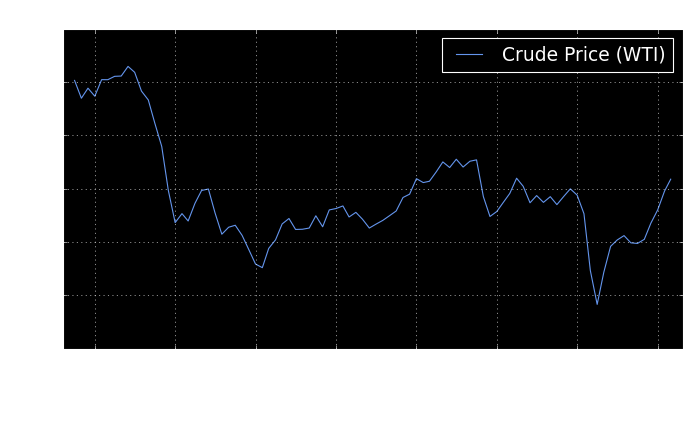

In [26]:
# WTI prices
fig, ax1=plt.subplots(frameon=False, figsize=(10,5))

ax1.set_xlabel('Date')
ax1.set_ylabel('Crude Prices (WTI)')
ax1.plot(WTI_date_df['Date'], WTI_date_df['Crude Price'], color='CornflowerBlue')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=45)
ax1.tick_params(axis='y')
ax1.set_title("Crude Prices")
ax1.grid()
plt.margins(x=.02)
# defining legend style and data
blue_line = mlines.Line2D([], [], color='CornflowerBlue', label='Crude Price (WTI)')
plt.legend(handles=[blue_line],loc='upper right')
plt.savefig("Crude_Storage_Images/Crude_Prices.png", bbox_inches='tight')

#### Crude and Gasoline Storage

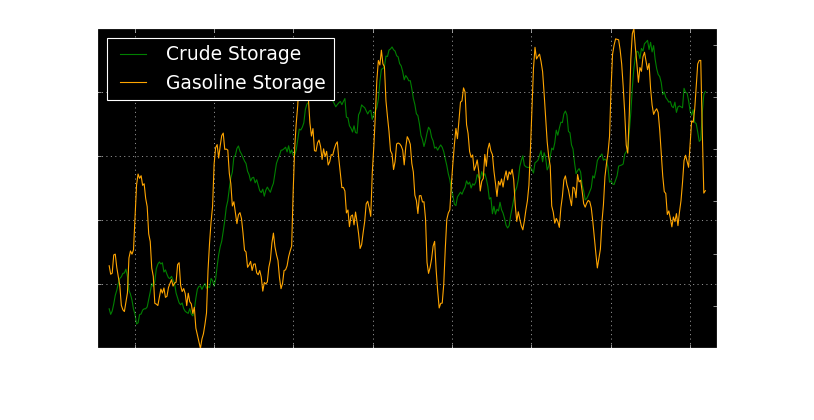

In [27]:
# plot crude storage and gasoline storage on one graph with two axes
fig, ax1=plt.subplots(frameon=False, figsize=(10,5))
ax1.set_xlabel('Date')
ax1.set_ylabel('Crude Storage')
ax1.plot(crude_date_df['Date'],crude_date_df['Crude'], color='g')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=45)
ax1.tick_params(axis='y')
ax1.set_title("Crude And Gasoline Storage")
ax1.grid(False)

ax2=ax1.twinx()
ax2.set_ylabel('Gasoline Storage')
ax2.plot(gasoline_date_df['Date'], gasoline_date_df['Gas Storage'], color='orange')
ax2.tick_params(axis='y')
plt.margins(x=.02)
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax1.grid()
ax2.margins(x=.02) 
ax1.margins(x=.02) 
# defining legend style and data
green_line = mlines.Line2D([], [], color='g', label='Crude Storage')
orange_line = mlines.Line2D([], [], color='orange', label='Gasoline Storage')
plt.legend(handles=[green_line, orange_line], loc='upper left')

plt.savefig("Crude_Storage_Images/Crude_vs_Gasoline_Storage_API.png", bbox_inches='tight')

#### Crude Storage Vs. Crude Prices for 2020

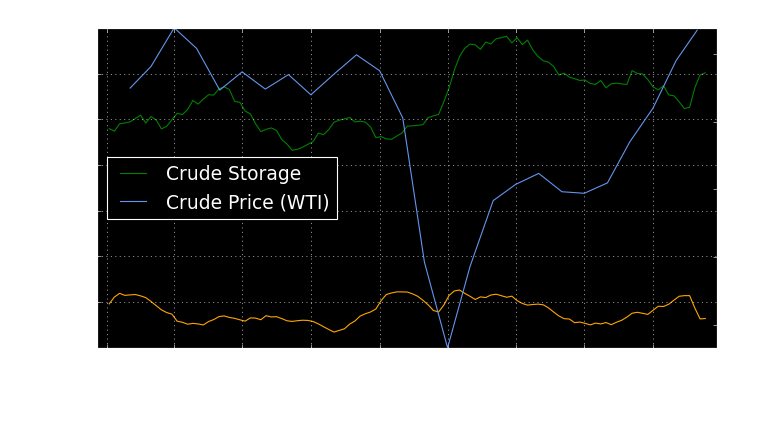

In [28]:
start_date_crude = "2019-01-01"
end_date_crude =  datetime.datetime.now()
crude_date_storage_df = crude_df[(crude_df['Date']> start_date_crude) & (crude_df['Date']< end_date_crude)]
WTI_date_storage_df = WTI_df[(WTI_df['Date']> start_date_crude) & (WTI_df['Date']< end_date_crude)]
gasoline_date_date_df=gasoline_df[(gasoline_df['Date']>start_date_crude)& (gasoline_df['Date']< end_date_crude)]
# plot just crude prices on one graph
fig, ax1=plt.subplots(frameon=False, figsize=(10,5))

ax1.set_xlabel('Date')
ax1.set_ylabel('Crude And Gasoline Storage')
ax1.plot(crude_date_storage_df['Date'],crude_date_storage_df['Crude'], color='g')
ax1.plot(gasoline_date_date_df['Date'],gasoline_date_date_df['Gas Storage'], color='orange')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=45)
ax1.tick_params(axis='y')
ax1.set_title("Crude Storage Vs. Crude Prices For 2020")

ax2=ax1.twinx()
ax2.set_ylabel('Crude Prices (WTI)')
ax2.plot(WTI_date_storage_df['Date'], WTI_date_storage_df['Crude Price'], color='CornflowerBlue')
ax2.tick_params(axis='y')

ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.grid()

ax2.margins(x=.02) 
ax1.margins(x=.02) 

# defining legend style and data
green_line = mlines.Line2D([], [], color='g', label='Crude Storage')
blue_line = mlines.Line2D([], [], color='CornflowerBlue', label='Crude Price (WTI)')
plt.legend(handles=[green_line,blue_line],loc='center left')
plt.savefig("Crude_Storage_Images/Crude_Storage_Vs_Crude_Prices_For_2020.png", bbox_inches='tight')

#### Crude Storage Vs. Crude Prices

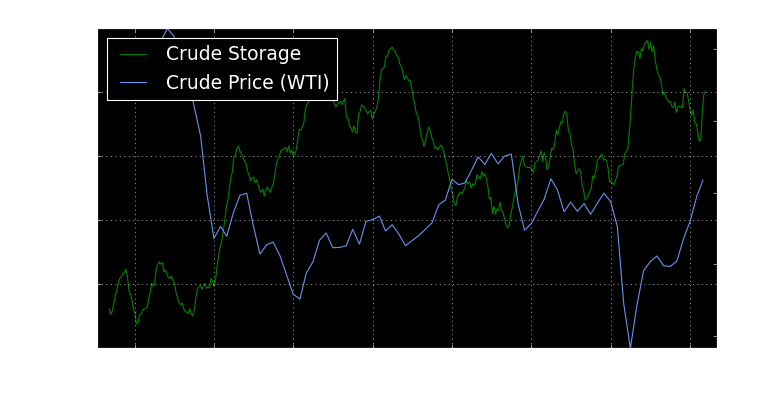

In [29]:
# plot just crude prices on one graph
fig, ax1=plt.subplots(frameon=False, figsize=(10,5))

ax1.set_xlabel('Date')
ax1.set_ylabel('Crude Storage')
ax1.plot(crude_date_df['Date'],crude_date_df['Crude'], color='g')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=45)
ax1.tick_params(axis='y')
ax1.set_title("Crude Storage Vs. Crude Prices")

ax2=ax1.twinx()
ax2.set_ylabel('Crude Prices (WTI)')
ax2.plot(WTI_date_df['Date'], WTI_date_df['Crude Price'], color='CornflowerBlue')
ax2.tick_params(axis='y')

ax2.margins(x=.02) 
ax1.margins(x=.02) 

ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.grid()

# defining legend style and data
green_line = mlines.Line2D([], [], color='g', label='Crude Storage')
blue_line = mlines.Line2D([], [], color='CornflowerBlue', label='Crude Price (WTI)')
plt.legend(handles=[green_line,blue_line],loc='upper left')
plt.savefig("Crude_Storage_Images/Crude_Storage_Vs_Crude_Prices.png", bbox_inches='tight')

#### Gasoline Storage Vs. Crude Prices

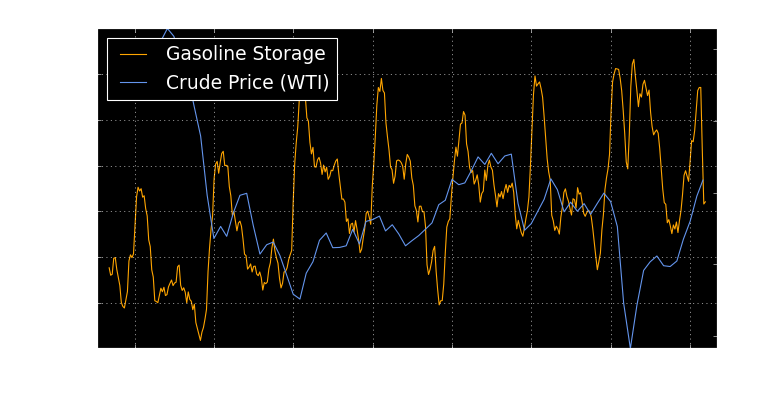

In [30]:
# plot Gasoline Storage and Prices

fig, ax1=plt.subplots(frameon=False, figsize=(10,5))

ax1.set_xlabel('Date')
ax1.set_ylabel('Gasoline Storage')
ax1.plot(gasoline_date_df['Date'], gasoline_date_df['Gas Storage'], color='orange')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=45)
ax1.tick_params(axis='y')
ax1.set_title("Gasoline Storage Vs. Crude Prices")
plt.margins(x=.02)
ax2=ax1.twinx()
ax2.set_ylabel('Crude Prices (WTI)')
ax2.plot(WTI_date_df['Date'], WTI_date_df['Crude Price'], color='CornflowerBlue')
ax2.tick_params(axis='y')
ax1.grid()

ax2.margins(x=.02) 
ax1.margins(x=.02) 

ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# defining legend style and data
green_line = mlines.Line2D([], [], color='orange', label='Gasoline Storage')
blue_line = mlines.Line2D([], [], color='CornflowerBlue', label='Crude Price (WTI)')
plt.legend(handles=[green_line,blue_line],loc='upper left')
plt.savefig("Crude_Storage_Images/Gasoline_Storage_Vs_Crude_Prices.png", bbox_inches='tight')

# Year by Year Comparison

In [31]:
fifteen=gasoline_df[(gasoline_df['Date']>"2015-01-01") & (gasoline_df['Date']< "2015-12-31")]
sixteen=gasoline_df[(gasoline_df['Date']>"2016-01-01") & (gasoline_df['Date']< "2016-12-31")]
seventeen=gasoline_df[(gasoline_df['Date']>"2017-01-01") & (gasoline_df['Date']< "2017-12-31")]
eighteen=gasoline_df[(gasoline_df['Date']>"2018-01-01") & (gasoline_df['Date']< "2018-12-31")]
nineteen=gasoline_df[(gasoline_df['Date']>"2019-01-01") & (gasoline_df['Date']< "2019-12-31")]
twenty=gasoline_df[(gasoline_df['Date']>"2012-01-01") & (gasoline_df['Date']< datetime.datetime.now())]

In [32]:
fifteen.reset_index(inplace= True )
fifteen['Date']=pd.to_datetime(fifteen['Date'])
fifteen.reset_index(inplace=True)
fifteen['Day'] = fifteen['Date'].dt.day
fifteen['Month'] = fifteen['Date'].dt.month
fifteen['Year'] = fifteen['Date'].dt.year

list_months=[]
for x in fifteen['Month']:
    list_months.append(calendar.month_name[x])
fifteen['Months']=list_months
fifteen.drop(['Date','Month'], axis=1, inplace=True)
fifteen.head()

,level_0,index,Gas Storage,Day,Year,Months
0,0,1304,237163,2,2015,January
1,1,1305,240334,9,2015,January
2,2,1306,240922,16,2015,January
3,3,1307,238335,23,2015,January
4,4,1308,240670,30,2015,January


# Duc vs Prices

#### Total DUC Inventory Vs. Crude Prices

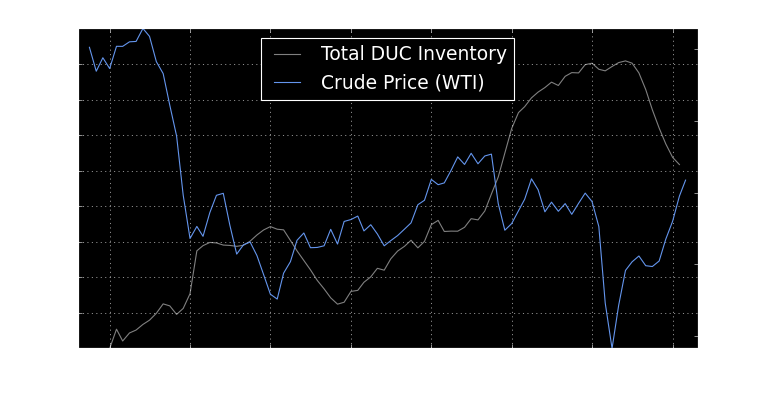

In [33]:
# plot just crude prices on one graph
fig, ax1=plt.subplots(frameon=False, figsize=(10,5))

ax1.set_xlabel('Date')
ax1.set_ylabel('DUC Inventory')
ax1.plot(DUCInventory_df.index,DUCInventory_df['Total_DUC'], color='grey')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=45)
ax1.tick_params(axis='y')
ax1.set_title("Total DUC Inventory Vs. Crude Prices")

ax2=ax1.twinx()
ax2.set_ylabel('Crude Prices (WTI)')
ax2.plot(WTI_date_df['Date'], WTI_date_df['Crude Price'], color='CornflowerBlue')
ax2.tick_params(axis='y')

ax2.margins(x=.02) 
ax1.margins(x=.02) 

ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.grid()

# defining legend style and data
grey = mlines.Line2D([], [], color='grey', label='Total DUC Inventory')
blue_line = mlines.Line2D([], [], color='CornflowerBlue', label='Crude Price (WTI)')
plt.legend(handles=[grey,blue_line],loc='upper center')
plt.savefig("DUC_Images/Total_DUC_Inventory_vs_Prices.png", bbox_inches='tight')

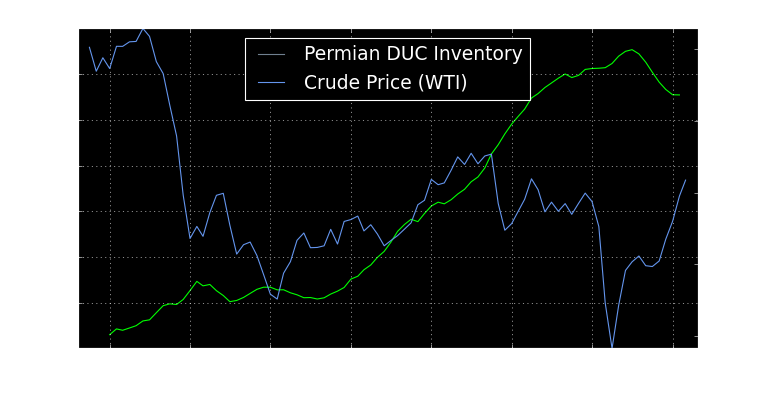

In [34]:
# plot just crude prices on one graph
fig, ax1=plt.subplots(frameon=False, figsize=(10,5))

ax1.set_xlabel('Date')
ax1.set_ylabel('DUC Inventory')
ax1.plot(DUCInventory_df.index,DUCInventory_df['Permian_DUC'], color='lime')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
_=plt.xticks(rotation=45)
ax1.tick_params(axis='y')
ax1.set_title("Permian DUC Inventory Vs. Crude Prices")

ax2=ax1.twinx()
ax2.set_ylabel('Crude Prices (WTI)')
ax2.plot(WTI_date_df['Date'], WTI_date_df['Crude Price'], color='CornflowerBlue')
ax2.tick_params(axis='y')

ax2.margins(x=.02) 
ax1.margins(x=.02) 

ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.grid()

# defining legend style and data
grey = mlines.Line2D([], [], color='slategrey', label='Permian DUC Inventory')
blue_line = mlines.Line2D([], [], color='CornflowerBlue', label='Crude Price (WTI)')
plt.legend(handles=[grey,blue_line],loc='upper center')
plt.savefig("DUC_Images/Total_DUC_Inventory_vs_Prices.png", bbox_inches='tight')

In [35]:
gasoline_df.to_csv("Data/GasolineCleaned(9.5).csv")
crude_df.to_csv("Data/CrudeCleaned(9.5).csv")
WTI_df.to_csv("Data/WTIPricesCleaned(9.5).csv")

In [36]:
DUCInventory_df.to_csv("Data/DUCInventoryClean.csv")